# Customizing Tree Search

In [20]:
# your other imports here ...
import sys, os
import pandas as pd
import matplotlib.pyplot as plt

# TODO: replace with your path/to/ninarow
ninarowdir = os.path.dirname(os.getcwd())
modelfitdir = ninarowdir + "/model_fitting/"
# os.listdir(modelfitdir)

# sets the import path to the model-fitting directory
sys.path.insert(0, modelfitdir)
from parsers import *
from model_fit import *
from utils import *
import model_fit
from tqdm import tqdm
from tree_search import *

# WARNING: %load_ext autoreload and %autoreload 2 may interfere with 
# the Multi-threading processes!
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Handling

### File Formatting
The data columns should be ordered: 

    - black_pieces (binary), 
    - white_pieces (binary), 
    - player_color (Black/White), 
    - move (binary), 
    - response time (not used in fitting), 
    - [group_id] (optional), 
    - participant_id

for more info, see `parsers.py`

# Fitting the Model to Data

In [21]:
data_path = "../data"
output_path = "../data/out"
n_splits = 5
fold_number = 1
threads = 1
random_sample = False
verbose = True

print(f"Building output directory at {output_path}")
os.makedirs(output_path, exist_ok = True)

Building output directory at ../data/out


## Comparing Original Code with Custom Code

In [ ]:
from multiprocessing import Pool, Value, set_start_method
from prodict import Prodict

# first, we have to check to see if all the splits are there ...
assert np.all([f"{i + 1}.csv" in os.listdir(data_path) for i in range(n_splits)])
print("Detected splits in this directory. Loading splits ...")

# then we read them in
splits = [pd.read_csv(f"{data_path}/{i + 1}.csv") for i in range(n_splits)]

# we convert every row of our CSV to a "CSVMove object" using df_to_CSVMove - we do so for all the splits
# CSVMove is a class that is defined in the parsers.py file 
fold_data = [[csvmove for csvmove in df_to_CSVMove(split, warn = False)] for split in splits]

random.seed(10)
model_fit.initialize_thread_pool(1, manual_seed = 10)

args = Prodict()
args.random_sample = False
args.verbose = True
args.threads = 1

model_fitter = ModelFitter(DefaultModel(), args = args)

params, loglik_train, loglik_test = model_fitter.cross_validate(fold_data, fold_number - 1)


Detected splits in this directory. Loading splits ...
Thread 0: Base Seed 10, Seed: 10, Random Number: 601088376405717203

Setting manual seed 10 for single-thread
Cross validating split 1 against the other 4 splits
Beginning model fit pre-processing: log-likelihood estimation


  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:15,  1.68s/it]

	Time taken: 1.685272216796875 since Start, 1.6827397346496582 since Loop


 20%|██        | 2/10 [00:03<00:12,  1.55s/it]

	Time taken: 3.1422667503356934 since Start, 1.4543578624725342 since Loop


 30%|███       | 3/10 [00:05<00:13,  1.88s/it]

	Time taken: 5.418270826339722 since Start, 2.273815631866455 since Loop


 40%|████      | 4/10 [00:07<00:10,  1.77s/it]

	Time taken: 7.007265567779541 since Start, 1.586728811264038 since Loop


 50%|█████     | 5/10 [00:08<00:07,  1.59s/it]

	Time taken: 8.288264513015747 since Start, 1.2787487506866455 since Loop


 60%|██████    | 6/10 [00:10<00:06,  1.74s/it]

	Time taken: 10.32826852798462 since Start, 2.0378661155700684 since Loop


 70%|███████   | 7/10 [00:12<00:05,  1.85s/it]

	Time taken: 12.39227032661438 since Start, 2.0618679523468018 since Loop


 80%|████████  | 8/10 [00:13<00:03,  1.72s/it]

	Time taken: 13.82327151298523 since Start, 1.4288158416748047 since Loop


 90%|█████████ | 9/10 [00:15<00:01,  1.73s/it]

	Time taken: 15.59626579284668 since Start, 1.7708747386932373 since Loop


100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


	Time taken: 16.63226580619812 since Start, 1.0338928699493408 since Loop


100%|██████████| 24/24 [00:00<00:00, 8437.83it/s]

[4. 4. 2. 2. 4. 1. 5. 5. 1. 1. 5. 3. 4. 4. 1. 3. 4. 5. 2. 4. 5. 3. 2. 5.]


	Time taken: 19.545300722122192 since Start, 2.698770046234131 since Loop
	[0] NLL: 59.1321 Params: [2.001, 0.02, 0.2, 0.05, 1.2, 0.801, 1.001, 0.4, 3.501, 5.0]
Beginning optimization of a STOCHASTIC objective function

 Iteration    f-count      E[f(x)]        SD[f(x)]           MeshScale          Method              Actions
     0           1         59.1321             nan               1                                  
	Time taken: 20.124260663986206 since Start, 0.5718865394592285 since Loop
	[1] NLL: 76.8565 Params: [1.053, 0.68, 0.147, 0.292, 0.539, 0.952, -1.899, -1.372, -4.072, -3.799]
	Time taken: 38.2952995300293 since Start, 18.169737339019775 since Loop
	[2] NLL: 69.9426 Params: [1.334, 0.294, 0.414, 0.005, 1.939, -4.663, -4.106, 4.424, -3.281, 2.393]
	Time taken: 39.21727728843689 since Start, 0.9200358390808105 since Loop
	[3] NLL: 80.3261 Params: [1.632, 0.782, 0.037, 0.156, 1.082, -3.052, 3.237, 1.782, -0.542, -3.545]
	Time taken: 39.775266885757446 since Start, 0.55


KeyboardInterrupt



Process ForkPoolWorker-18:
Traceback (most recent call last):
  File "/ext3/miniconda3/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/ext3/miniconda3/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/ext3/miniconda3/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/scratch/hl3976/ma_lab/ninarow/model_fitting/model_fit.py", line 223, in estimate_log_lik_ibs
    search.complete_search()
  File "/scratch/hl3976/ma_lab/ninarow/model_fitting/fourbynine.py", line 1580, in complete_search
    return _swig_fourbynine.AbstractSearch_complete_search(self)
KeyboardInterrupt


We are now ready to begin running our model. We will begin with the default model and then feed it to our  `ModelFitter` class. Note that this code may take a very long time to run (a couple hours)...

If you are using multiple threads and seeing a thread-related error, please make sure to turn OFF `%load_ext autoreload` and `%autoreload 2` from the import statements above

In [19]:
from multiprocessing import Pool, Value, set_start_method
from prodict import Prodict

# first, we have to check to see if all the splits are there ...
assert np.all([f"{i + 1}.csv" in os.listdir(data_path) for i in range(n_splits)])
print("Detected splits in this directory. Loading splits ...")

# then we read them in
splits = [pd.read_csv(f"{data_path}/{i + 1}.csv") for i in range(n_splits)]

# we convert every row of our CSV to a "CSVMove object" using df_to_CSVMove - we do so for all the splits
# CSVMove is a class that is defined in the parsers.py file 
fold_data = [[csvmove for csvmove in df_to_CSVMove(split, warn = False)] for split in splits]

random.seed(10)
initialize_thread_pool(1, manual_seed = 10)

args = Prodict()
args.random_sample = None
args.verbose = True
args.threads = 1

cross_validate(TreeSearch(), splits, leave_out_idx=fold_number - 1, subsample = args.random_sample, threads = args.threads)

Detected splits in this directory. Loading splits ...
Thread 0: Base Seed 10, Seed: 10, Random Number: 601088376405717203



Setting manual seed 10 for single-thread
Cross validating split 1 against the other 4 splits
[Preprocessing] Initial log-likelihood estimation


 10%|█         | 1/10 [00:01<00:14,  1.63s/it]

	Time taken: 1.6306250095367432 since Start, 1.6260316371917725 since Loop


 20%|██        | 2/10 [00:03<00:12,  1.51s/it]

	Time taken: 3.066620349884033 since Start, 1.434668779373169 since Loop


 30%|███       | 3/10 [00:05<00:12,  1.84s/it]

	Time taken: 5.304620742797852 since Start, 2.2367162704467773 since Loop


 40%|████      | 4/10 [00:06<00:10,  1.73s/it]

	Time taken: 6.869629859924316 since Start, 1.5638072490692139 since Loop


 50%|█████     | 5/10 [00:08<00:07,  1.56s/it]

	Time taken: 8.131624698638916 since Start, 1.2608206272125244 since Loop


 60%|██████    | 6/10 [00:10<00:06,  1.71s/it]

	Time taken: 10.138623714447021 since Start, 2.0058228969573975 since Loop


 70%|███████   | 7/10 [00:12<00:05,  1.82s/it]

	Time taken: 12.175622463226318 since Start, 2.035271406173706 since Loop


 80%|████████  | 8/10 [00:13<00:03,  1.69s/it]

	Time taken: 13.587623596191406 since Start, 1.4108095169067383 since Loop


 90%|█████████ | 9/10 [00:15<00:01,  1.71s/it]

	Time taken: 15.338619470596313 since Start, 1.7498078346252441 since Loop


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]

	Time taken: 16.359619140625 since Start, 1.0196878910064697 since Loop


	Time taken: 19.225631952285767 since Start, 2.660083055496216 since Loop
	[0] NLL: 59.1321 Params: [2.001, 0.02, 0.2, 0.05, 1.2, 0.801, 1.001, 0.4, 3.501, 5.0]
Beginning optimization of a STOCHASTIC objective function

 Iteration    f-count      E[f(x)]        SD[f(x)]           MeshScale          Method              Actions
     0           1         59.1321             nan               1                                  
	Time taken: 19.741631507873535 since Start, 0.510352373123169 since Loop
	[1] NLL: 76.8565 Params: [1.053, 0.68, 0.147, 0.292, 0.539, 0.952, -1.899, -1.372, -4.072, -3.799]
	Time taken: 36.4666543006897 since Start, 16.724289178848267 since Loop
	[2] NLL: 69.9426 Params: [1.334, 0.294, 0.414, 0.005, 1.939, -4.663, -4.106, 4.424, -3.281, 2.393]
	Time taken: 37.274630546569824 since Start, 0.8056237697601318 since Loop
	[3] NLL: 80.3261 Params: [1.632, 0.782, 0.037, 0.156, 1.082, -3.052, 3.237, 1.782, -0.542, -3.545]
	Time taken: 37.772624015808105 since Start, 0.49


KeyboardInterrupt



Process ForkPoolWorker-15:
Traceback (most recent call last):
  File "/ext3/miniconda3/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/ext3/miniconda3/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/ext3/miniconda3/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/scratch/hl3976/ma_lab/ninarow/model_fitting/tree_search.py", line 258, in parallel_log_likelihood
    predicted_move = self.model.predict(board)
  File "/scratch/hl3976/ma_lab/ninarow/model_fitting/tree_search.py", line 167, in predict
    search.complete_search()
  File "/scratch/hl3976/ma_lab/ninarow/model_fitting/fourbynine.py", line 1580, in complete_search
    return _swig_fourbynine.AbstractSearch_complete_search(self)
KeyboardInterrupt


In [32]:
from model_fit import *
random.seed(10)
initialize_thread_pool(1, manual_seed = 10)

model_fitter = ModelFitter(DefaultModel(), 
                           random_sample = random_sample, 
                           verbose = verbose, 
                           threads = threads)

model_fitter.fit_model(fold_data[fold_number - 1])

Setting manual seed 10 for single-thread
Thread 0: Base Seed 10, Seed: 10, Random Number: 601088376405717203

[Preprocessing] Initial log-likelihood estimation


100%|██████████| 6/6 [00:00<00:00, 14217.98it/s]


[0] NLL: 9.2936 Params: [2.001, 0.02, 0.2, 0.05, 1.2, 0.801, 1.001, 0.4, 3.501, 5.0]
Beginning optimization of a STOCHASTIC objective function

 Iteration    f-count      E[f(x)]        SD[f(x)]           MeshScale          Method              Actions
     0           1         9.29357             nan               1                                  
[1] NLL: 20.3258 Params: [1.053, 0.68, 0.147, 0.292, 0.539, 0.952, -1.899, -1.372, -4.072, -3.799]


KeyboardInterrupt: 

We can examine the fitted model parameters below ...

In [ ]:
loglik_train_df = pd.DataFrame(loglik_train, columns = ["loglik_train"])
loglik_test_df = pd.DataFrame(loglik_test, columns = ["loglik_test"])

print("Fitted Model Parameters")
param_df = pd.DataFrame(dict(zip(model_fitter.model.param_names, params), index = [0])).drop("index", axis = 1)
param_df

## Part 3: Saving Parameters

We will save the log likelihood for the train and test folds, as well as the parameters, as `{fold_number}_lltrain.csv`, `{fold_number}_lltest.csv`, and `{fold_number}_params.csv` in the directory specified by `{output_path}`

In [ ]:
loglik_train_df.to_csv(f"{output_path}/{fold_number}_lltrain.csv", index = False)
loglik_test_df.to_csv(f"{output_path}/{fold_number}_lltest.csv", index = False)
param_df.to_csv(f"{output_path}/{fold_number}_params.csv", index = False)

# Running an Existing Model

## Loading the Model Parameters

First, let's load our model parameters in from a csv file ...

In [5]:
param_path = f"{output_path}/{fold_number}_params.csv"
param_df = pd.read_csv(param_path)
params = param_df.iloc[0].values

# set the parameters of the model that will be used in the tree search
model = DefaultModel()
heuristic = model.create_heuristic(params)

## Predicting moves on an example board

Let's start by taking an arbitrary board state and run our model prediction on it ...

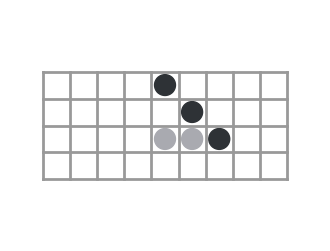

In [6]:
black = 16793616	
white = 12582912
show(black, white)

# create a fourbynineboard object out of our patterns ...
board = fourbynine_board(fourbynine_pattern(black), fourbynine_pattern(white))

In [7]:
search = model.create_search(params, heuristic, board)
search.complete_search()
best_move_index = heuristic.get_best_move(search.get_tree()).board_position

Predicted Move shown in BLUE


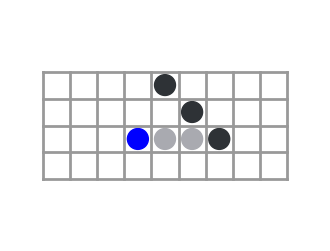

In [8]:
fig = plt.figure(figsize = (4, 3))
ax = plt.subplot(1, 1, 1)

show(black, white, existing_fig=(fig, ax))
add_circle(best_move_index, existing_fig=(fig, ax), color = "blue")
print("Predicted Move shown in BLUE")


## Make a Heatmap of Predictions from Multiple Searches
You might notice that there is noisiness in the behavior of the model. To show how the model behaves over several runs, we'll want to show a heatmap of the different predictions

100%|██████████| 100/100 [00:00<00:00, 106.67it/s]


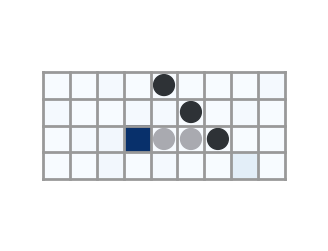

In [9]:
n_samples = 100
counts = np.zeros(36)
for _ in tqdm(range(n_samples), leave=True): 
    search = model.create_search(params, heuristic, board)
    search.complete_search()
    best_move_index = heuristic.get_best_move(search.get_tree()).board_position
    counts[best_move_index] += 1

fig = plt.figure(figsize = (4, 3))
ax = plt.subplot(1, 1, 1)
show(black, white, existing_fig=(fig, ax))

# the [::-1] is to flip the board because of a quirk in the way the board is plotted
# you basically have to mirror it over the y-axis (see "extent" below)
ax.imshow(counts.reshape(4, 9)[::-1], cmap = "Blues", extent=[85, 715, -160, -440], alpha = 1)